In [1]:
DATA_CSV = "../results/attractor_convergence.csv"

GENERATE_DATA = False
# Parameters for generating data
MODEL_DIRECTORY = "../models/random_nk3"
UPDATE = "asynchronous"
N_RANDOM = 30 # number of random models
DEBUG = False
NSQUARE_STEPS = 20 # number of steps for nsquare

# Figure configuration
MAIN_FIGURE_ID_1 = "5"
SUP_FIGURE_ID_1 = "s3"
METRICS_1 = ["precision", "specificity"]
METHODS_1 = None # plot all methods

MAIN_FIGURE_ID_2 = "6"
SUP_FIGURE_ID_2 = "s4"
METRICS_2 = ["rmsd", "kld"]
METHODS_2 = None # plot all methods
LIM = {"kld": (0, 1.5)}

FIGURE_DIR = "../results/figures"

In [2]:
import pandas as pd
from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.prime_implicants import percolate
from pyboolnet.state_transition_graphs import primes2stg

import sdmarkov.plotting.config as pc
from sdmarkov.attractors import get_predicted_attractors
from sdmarkov.basins import get_convergence_matrix
from sdmarkov.grouping import sd_grouping, null_grouping, random_grouping
from sdmarkov.matrix_operations import nsquare, compress_matrix, expand_matrix, get_rms_diff, get_kld, get_confusion_matrix
from sdmarkov.transition_matrix import get_transition_matrix, get_uniform_matrix
from sdmarkov.analysis.utils import load_or_generate_data, add_classification_metrics, network_level_metrics_df
from sdmarkov.plotting.figures import plot_violin_figure, plot_distribution_figure, save_figure

## Data generation or loading

In [3]:
def get_data_convergence(
    bnet,
    bnet_name=None,
    update="asynchronous",
    num_runs=30,
    DEBUG=False,
):
    """
    Compute network-level comparison metrics (RMSD, KLD, reachability)
    for SD, null, uniform, and random groupings of a Boolean network.

    Returns a long-format DataFrame with one row per method per run.
    """

    rows = []

    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}

    # Percolate constant nodes
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return pd.DataFrame(rows)

    percolated_bnet = primes2bnet(percolated_primes)
    n_states = 2 ** len(percolated_primes)

    # Full state transition graph and matrix
    stg = primes2stg(percolated_primes, update)
    T = get_transition_matrix(stg, DEBUG=DEBUG)

    # grouped transition matrices
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)

    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)

    # Predicted attractors
    predicted_attractor_indices = get_predicted_attractors(Tsd, sd_indices, as_indices=True, DEBUG=DEBUG)
    n_attractors = len(predicted_attractor_indices)

    if n_attractors < 2:
        return pd.DataFrame(rows)

    # Actual convergence matrix
    T_inf = nsquare(T, NSQUARE_STEPS, DEBUG=DEBUG)
    T_conv = get_convergence_matrix(T_inf, predicted_attractor_indices, DEBUG=DEBUG)

    # reference convergence matrix
    uniform_conv = get_uniform_matrix(n_states, n_attractors)

    # Grouped transition matrices
    def grouped_convergence(T_grouped, indices, predicted_attractors, DEBUG=False):
        T_grouped_inf = nsquare(T_grouped, NSQUARE_STEPS, DEBUG=DEBUG)
        T_grouped_inf_expanded = expand_matrix(T_grouped_inf, indices, DEBUG=DEBUG)
        return get_convergence_matrix(T_grouped_inf_expanded,predicted_attractors,DEBUG=DEBUG)

    sd_conv = grouped_convergence(Tsd, sd_indices, predicted_attractor_indices, DEBUG=DEBUG)
    null_conv = grouped_convergence(Tnull, null_indices, predicted_attractor_indices, DEBUG=DEBUG)

    # Helper to add metrics to rows
    def add_metrics(method, conv_matrix, run=None):
        rmsd_val = get_rms_diff(T_conv, conv_matrix, partial=True, DEBUG=DEBUG)
        kld_val = get_kld(T_conv, conv_matrix, partial=True, DEBUG=DEBUG)
        TP, FP, TN, FN = get_confusion_matrix(T_conv, conv_matrix, partial=True, DEBUG=DEBUG)

        rows.append({
            "bnet": bnet_name,
            "method": method,
            "run": run,
            "rmsd": rmsd_val,
            "kld": kld_val,
            "TP": TP,
            "FP": FP,
            "TN": TN,
            "FN": FN,
            "n_states": n_states,
            "n_attractors": n_attractors,
            "update_scheme": update
        })

    # Deterministic/reference methods
    add_metrics("sd_mc", sd_conv)
    add_metrics("null_mc", null_conv)
    add_metrics("ref", uniform_conv)

    # Random runs
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        random_conv = grouped_convergence(Trandom, random_indices, predicted_attractor_indices, DEBUG=DEBUG)

        add_metrics("random_mc", random_conv, run=i)

    return pd.DataFrame(rows)

In [4]:
df = load_or_generate_data(
    data_csv=DATA_CSV,
    generate_data=GENERATE_DATA,
    data_function=get_data_convergence,
    model_directory=MODEL_DIRECTORY,
    update=UPDATE,
    n_random=N_RANDOM,
    debug=DEBUG,
)

Loaded cached results from ../results/attractor_convergence.csv.


In [5]:
print("Preview of results DataFrame:")
display(df.head())

print("\nDataFrame shape:", df.shape)
print("Methods present:", df.method.unique())
print("Number of unique networks:", df.bnet.nunique())

Preview of results DataFrame:


,bnet,method,run,rmsd,kld,TP,FP,TN,FN,n_states,n_attractors,update_scheme
0,n010_000.bnet,sd_mc,NaN,0.073292,0.015284,1408,0,640,0,1024,2,asynchronous
1,n010_000.bnet,null_mc,NaN,0.423820,0.478137,1408,576,64,0,1024,2,asynchronous
2,n010_000.bnet,ref,NaN,0.441869,0.521459,1408,640,0,0,1024,2,asynchronous
3,n010_000.bnet,random_mc,0.0,0.421663,0.474490,1408,576,64,0,1024,2,asynchronous
4,n010_000.bnet,random_mc,1.0,0.426781,0.483176,1408,576,64,0,1024,2,asynchronous



DataFrame shape: (1518, 12)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']
Number of unique networks: 46


## Data analysis

In [6]:
# filter out networks with a single attractor
df_multi = df[df["n_attractors"] > 1].copy()

# add precision, recall, specificity, and NPV
df_multi = add_classification_metrics(df_multi)

print("Added classification metrics")
print("DataFrame shape:", df_multi.shape)
print("Methods present:", df_multi.method.unique())
print("Number of unique networks:", df_multi.bnet.nunique())

display(df_multi.head())

Added classification metrics
DataFrame shape: (1518, 16)
Methods present: ['sd_mc' 'null_mc' 'ref' 'random_mc']
Number of unique networks: 46


,bnet,method,run,rmsd,kld,TP,FP,TN,FN,n_states,n_attractors,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,sd_mc,NaN,0.073292,0.015284,1408,0,640,0,1024,2,asynchronous,1.000000,1.0,1.0,1.0
1,n010_000.bnet,null_mc,NaN,0.423820,0.478137,1408,576,64,0,1024,2,asynchronous,0.709677,1.0,0.1,1.0
2,n010_000.bnet,ref,NaN,0.441869,0.521459,1408,640,0,0,1024,2,asynchronous,0.687500,1.0,0.0,NaN
3,n010_000.bnet,random_mc,0.0,0.421663,0.474490,1408,576,64,0,1024,2,asynchronous,0.709677,1.0,0.1,1.0
4,n010_000.bnet,random_mc,1.0,0.426781,0.483176,1408,576,64,0,1024,2,asynchronous,0.709677,1.0,0.1,1.0


In [7]:
df_metrics = network_level_metrics_df(df=df_multi)

print("Preview of network-level metrics DataFrame:")
display(df_metrics.head())

print("\nDataFrame shape:", df_metrics.shape)
print("Methods present:", df_metrics.method.unique())
print("Number of unique networks:", df_metrics.bnet.nunique())

print("\nNetwork-level classification metrics:")
metrics = ["rmsd", "kld", "precision", "recall", "specificity", "npv"]
summary = (
    df_metrics
    .groupby("method")[metrics]
    .agg(["mean", "min", "median", "max"])
)

display(summary)

Preview of network-level metrics DataFrame:


,bnet,method,rmsd,kld,TP,FP,TN,FN,n_states,n_attractors,update_scheme,precision,recall,specificity,npv
0,n010_000.bnet,null_mc,0.423820,0.478137,1408.0,576.0,64.0,0.0,1024.0,2.0,asynchronous,0.709677,1.0,0.100000,1.0
1,n010_000.bnet,random_mc,0.423475,0.477561,1408.0,576.0,64.0,0.0,1024.0,2.0,asynchronous,0.709677,1.0,0.100000,1.0
2,n010_000.bnet,ref,0.441869,0.521459,1408.0,640.0,0.0,0.0,1024.0,2.0,asynchronous,0.687500,1.0,0.000000,NaN
3,n010_000.bnet,sd_mc,0.073292,0.015284,1408.0,0.0,640.0,0.0,1024.0,2.0,asynchronous,1.000000,1.0,1.000000,1.0
4,n010_001.bnet,null_mc,0.304786,1.068623,116.0,180.0,24.0,0.0,64.0,5.0,asynchronous,0.391892,1.0,0.117647,1.0



DataFrame shape: (184, 15)
Methods present: ['null_mc' 'random_mc' 'ref' 'sd_mc']
Number of unique networks: 46

Network-level classification metrics:


rmsd                                     kld            \
               mean       min    median       max      mean       min   
method                                                                  
null_mc    0.299748  0.000000  0.324377  0.663478  0.512765  0.000000   
random_mc  0.295982  0.000000  0.309780  0.663313  0.502245  0.000000   
ref        0.372703  0.144227  0.379120  0.500000  0.638685  0.047403   
sd_mc      0.130431  0.000000  0.137484  0.498000  0.118614  0.000000   

                              precision            ... recall       \
             median       max      mean       min  ... median  max   
method                                             ...               
null_mc    0.471609  1.416023  0.741072  0.256000  ...    1.0  1.0   
random_mc  0.471366  1.410800  0.743421  0.256000  ...    1.0  1.0   
ref        0.693147  1.386294  0.643828  0.250000  ...    1.0  1.0   
sd_mc      0.070566  0.625135  0.972632  0.816901  ...    1.0  1.0   

          specificity                           npv                   
                 mean       min    median  max mean  min median  max  
method                                                                
null_mc      0.273529  0.005102  0.133929  1.0  1.0  1.0    1.0  1.0  
random_mc    0.278713  0.005102  0.133929  1.0  1.0  1.0    1.0  1.0  
ref          0.000000  0.000000  0.000000  0.0  NaN  NaN    NaN  NaN  
sd_mc        0.903626  0.040816  0.987291  1.0  1.0  1.0    1.0  1.0  

[4 rows x 24 columns]

## Plotting

In [8]:
pc.apply_style()

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


PosixPath('../results/figures/Figure_5_Attractor_reachability.png')

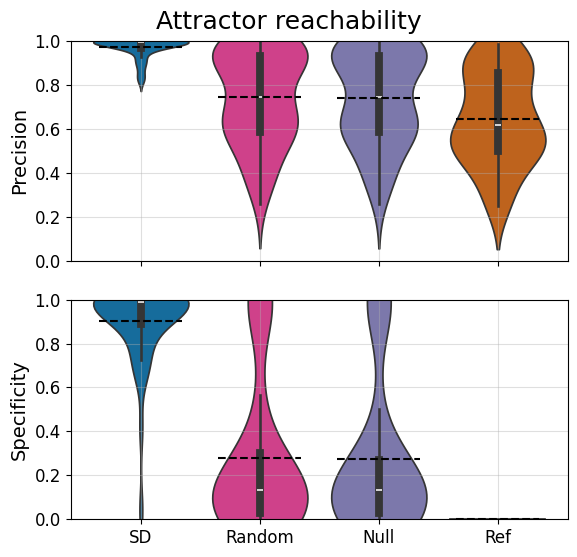

In [9]:
fig1_1 = plot_violin_figure(df_metrics, metrics=METRICS_1, figure_id=MAIN_FIGURE_ID_1)

save_figure(fig1_1, figure_id=MAIN_FIGURE_ID_1, outdir=FIGURE_DIR)

/home/troonmel/SDMarkov/sdmarkov/src/sdmarkov/plotting/figures.py:179: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


PosixPath('../results/figures/Figure_s3_Attractor_reachability.png')

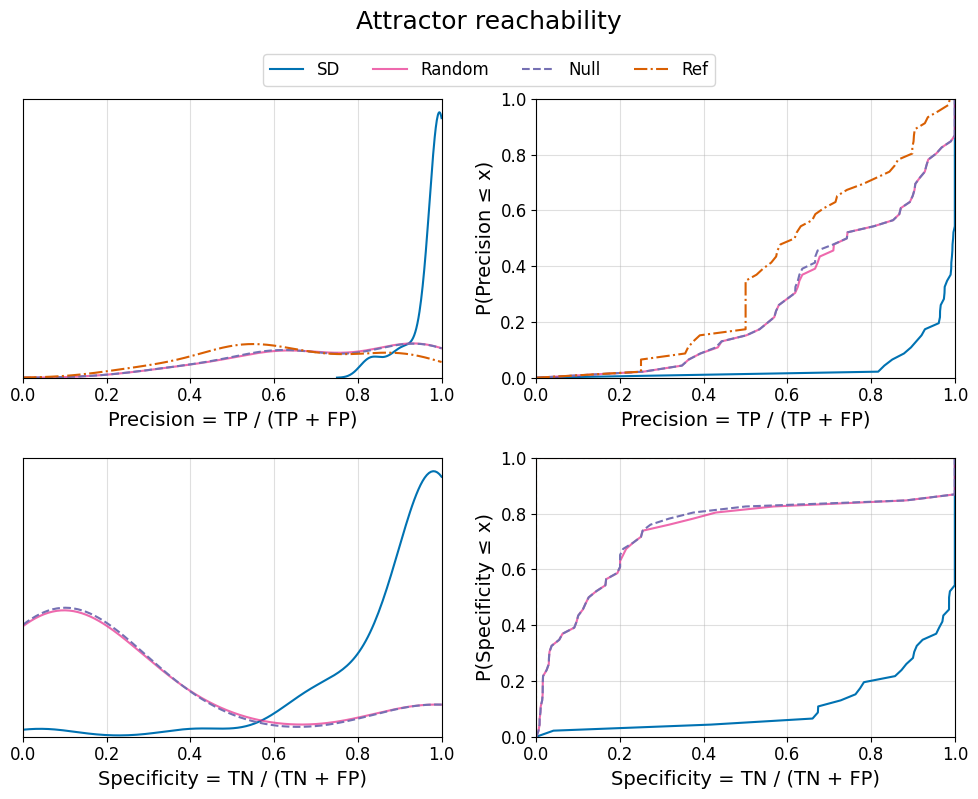

In [10]:
fig1_2 = plot_distribution_figure(df_metrics, metrics=METRICS_1, figure_id=SUP_FIGURE_ID_1)

save_figure(fig1_2, figure_id=SUP_FIGURE_ID_1, outdir=FIGURE_DIR)

INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


PosixPath('../results/figures/Figure_6_Convergence_probabilities.png')

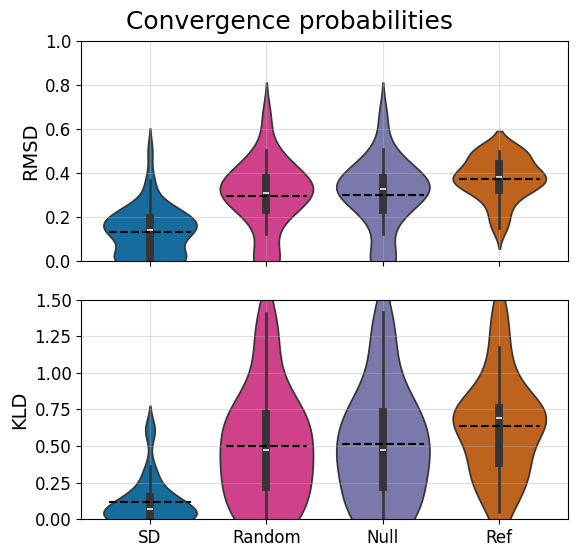

In [11]:
fig2_1 = plot_violin_figure(df_metrics, metrics=METRICS_2, figure_id=MAIN_FIGURE_ID_2, lim=LIM)

save_figure(fig2_1, figure_id=MAIN_FIGURE_ID_2, outdir=FIGURE_DIR)

PosixPath('../results/figures/Figure_s4_Convergence_probabilities.png')

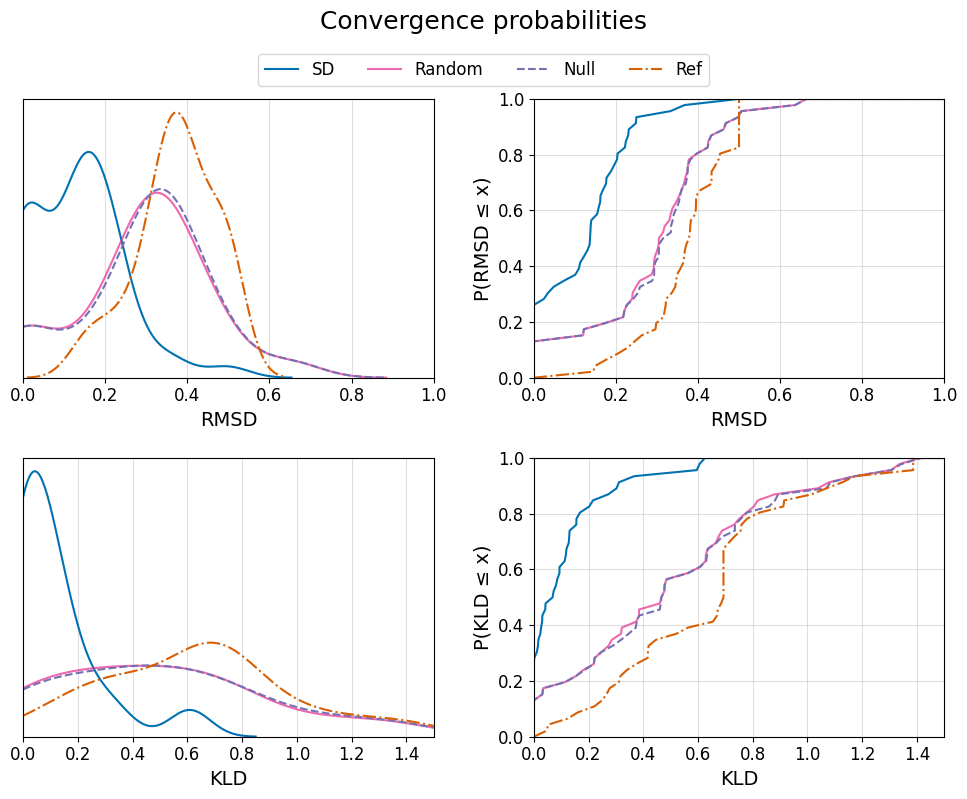

In [12]:
fig2_2 = plot_distribution_figure(df_metrics, metrics=METRICS_2, figure_id=SUP_FIGURE_ID_2, lim=LIM)

save_figure(fig2_2, figure_id=SUP_FIGURE_ID_2, outdir=FIGURE_DIR)